# 1. Import Library


In [1]:
# type: ignore

import os
import random
import pathlib

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# 2. Data Understanding/Preparation


In [2]:
# struktur direktori
base_dir = "./Dataset/fruits-skripsi/"
train_dir = os.path.join(base_dir, "Training")
test_dir = os.path.join(base_dir, "Test")

### Menghitung jumlah gambar yang ada pada folder training dan test dan membuat DataFrame


In [3]:
# Menampilkan nama data

data_dir = pathlib.Path(train_dir) 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) 
print(class_names)

['Apple' 'Avocado' 'Banana' 'Grape' 'Guava' 'Mango' 'Orange' 'Rambutan'
 'Salak' 'Watermelon']


In [4]:
# Menghitung total gambar

def count_images_in_directory(directory):
    total_images = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                total_images += 1
    return total_images

train_image_count = count_images_in_directory(train_dir)
test_image_count = count_images_in_directory(test_dir)

print("Total gambar pada folder training:", train_image_count)
print("Total gambar pada folder test:", test_image_count)

Total gambar pada folder training: 5309
Total gambar pada folder test: 1776


In [5]:
# Membuat DataFrame

def create_dataframe(data_path):
    df = []
    for c in os.listdir(data_path):
        class_folder = os.path.join(data_path, c)
        for f in os.listdir(class_folder):
            f_path = os.path.join(class_folder, f)
            if f_path.endswith('jpg'):
                df.append([f_path, c])
    return pd.DataFrame(df, columns=('filename', 'class'))

classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

df_train = create_dataframe(train_dir)
df_test = create_dataframe(test_dir)

df_train, df_test

(                                               filename       class
 0     ./Dataset/fruits-skripsi/Training\Apple\0_100.jpg       Apple
 1     ./Dataset/fruits-skripsi/Training\Apple\100_10...       Apple
 2     ./Dataset/fruits-skripsi/Training\Apple\101_10...       Apple
 3     ./Dataset/fruits-skripsi/Training\Apple\102_10...       Apple
 4     ./Dataset/fruits-skripsi/Training\Apple\103_10...       Apple
 ...                                                 ...         ...
 5304  ./Dataset/fruits-skripsi/Training\Watermelon\r...  Watermelon
 5305  ./Dataset/fruits-skripsi/Training\Watermelon\r...  Watermelon
 5306  ./Dataset/fruits-skripsi/Training\Watermelon\r...  Watermelon
 5307  ./Dataset/fruits-skripsi/Training\Watermelon\r...  Watermelon
 5308  ./Dataset/fruits-skripsi/Training\Watermelon\r...  Watermelon
 
 [5309 rows x 2 columns],
                                                filename       class
 0       ./Dataset/fruits-skripsi/Test\Apple\321_100.jpg       Apple
 1    

### Memisahkan data train sebesar 10%/20%/30% untuk data validasi

dan menjadikan perbandingan(split_dataset) menjadi 90:10, 80:20, 70:30


In [6]:
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=0)

df_train, df_val

(                                               filename       class
 5076  ./Dataset/fruits-skripsi/Training\Watermelon\r...  Watermelon
 1196  ./Dataset/fruits-skripsi/Training\Banana\r_129...      Banana
 3865  ./Dataset/fruits-skripsi/Training\Rambutan\111...    Rambutan
 729   ./Dataset/fruits-skripsi/Training\Avocado\r_15...     Avocado
 4813  ./Dataset/fruits-skripsi/Training\Salak\r_79_1...       Salak
 ...                                                 ...         ...
 4931  ./Dataset/fruits-skripsi/Training\Watermelon\2...  Watermelon
 3264  ./Dataset/fruits-skripsi/Training\Mango\r_283_...       Mango
 1653  ./Dataset/fruits-skripsi/Training\Grape\394_10...       Grape
 2607  ./Dataset/fruits-skripsi/Training\Guava\308_10...       Guava
 2732  ./Dataset/fruits-skripsi/Training\Guava\r_213_...       Guava
 
 [4247 rows x 2 columns],
                                                filename       class
 1003  ./Dataset/fruits-skripsi/Training\Banana\206_1...      Banana
 29   

### Menampilkan data


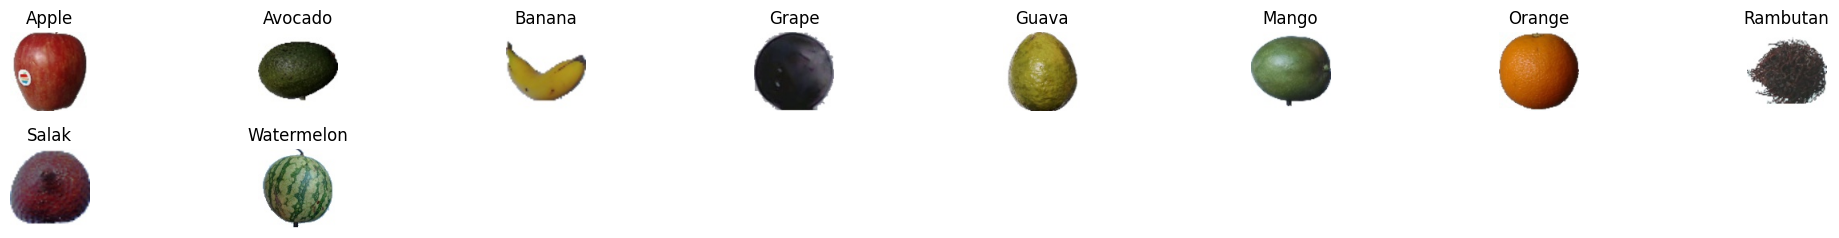

In [7]:
def view_random_image(target_dir, target_class):
    target_folder = os.path.join(target_dir, target_class)
    random_image = random.choice(os.listdir(target_folder))
    img = mpimg.imread(os.path.join(target_folder, random_image))

    return img

rows = 17
cols = 8

plt.figure(figsize=(20, 20))
for i, class_name in enumerate(class_names):
    img = view_random_image(target_dir=data_dir, target_class=class_name)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
plt.tight_layout()
plt.show()

# 3. Preprocessing Data

menggunakan ImageDataGenerator untuk melakukan Preprocessing data agar data lebih bervariasi


In [8]:
batch_size_train = 10
batch_size_val_test = 15

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
).flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='class',
    target_size=(100, 100),
    batch_size=batch_size_train,
    class_mode='categorical'  
)
val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='class',
    target_size=(100, 100),
    batch_size=batch_size_val_test,
    class_mode='categorical',
    shuffle=False
)
test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    df_test,
    x_col='filename',
    y_col='class',
    target_size=(100, 100),
    batch_size=batch_size_val_test,
    class_mode='categorical',
    shuffle=False
)
train_generator = train_gen
validation_generator = val_gen
test_generator = test_gen

Found 4247 validated image filenames belonging to 10 classes.
Found 1062 validated image filenames belonging to 10 classes.
Found 1776 validated image filenames belonging to 10 classes.


In [9]:
y_test = test_generator.classes

### 4. Perancangan Model CNN


In [10]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.summary()

c:\Users\nurfa_mk6kibp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,652,490 (25.38 MB)

 Trainable params: 6,652,490 (25.38 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3)


In [12]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(df_train) // batch_size_train,
    epochs=5,
    validation_data=val_gen,
    validation_steps=len(df_val) // batch_size_val_test,
    callbacks=[early_stopping],
    verbose=1,
)

Epoch 1/5


c:\Users\nurfa_mk6kibp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


424/424 ━━━━━━━━━━━━━━━━━━━━ 109s 252ms/step - accuracy: 0.6992 - loss: 0.8517 - val_accuracy: 0.9762 - val_loss: 0.0664
Epoch 2/5
424/424 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - accuracy: 1.0000 - loss: 0.0220 - val_accuracy: 1.0000 - val_loss: 0.0336
Epoch 3/5


c:\Users\nurfa_mk6kibp\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


424/424 ━━━━━━━━━━━━━━━━━━━━ 78s 184ms/step - accuracy: 0.9434 - loss: 0.1971 - val_accuracy: 0.9962 - val_loss: 0.0092
Epoch 4/5
424/424 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 5/5
424/424 ━━━━━━━━━━━━━━━━━━━━ 91s 215ms/step - accuracy: 0.9899 - loss: 0.0339 - val_accuracy: 0.9971 - val_loss: 0.0036


In [13]:
# save model

# model.save("./model/TFC-1.keras")

# 5. Hasil dan Evaluasi Model


In [14]:
eval_result = model.evaluate(test_generator)

119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9971 - loss: 0.0091


In [15]:
print("Test Accuracy:", eval_result[1] )
print("Test Loss:", eval_result[0] )

Test Accuracy: 0.9983108043670654
Test Loss: 0.005486306268721819


### Plot Accuracy and Loss


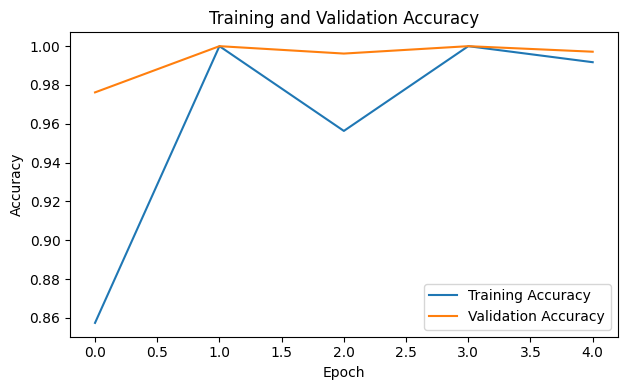

In [16]:
# Plot Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

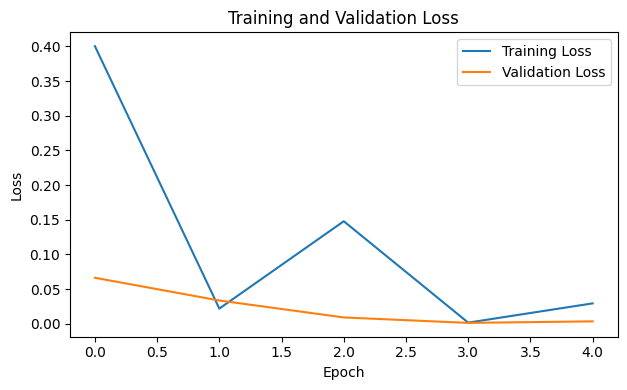

In [17]:
# Plot Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

### Confusion Matrix


In [18]:
# create confusion matrix

y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step


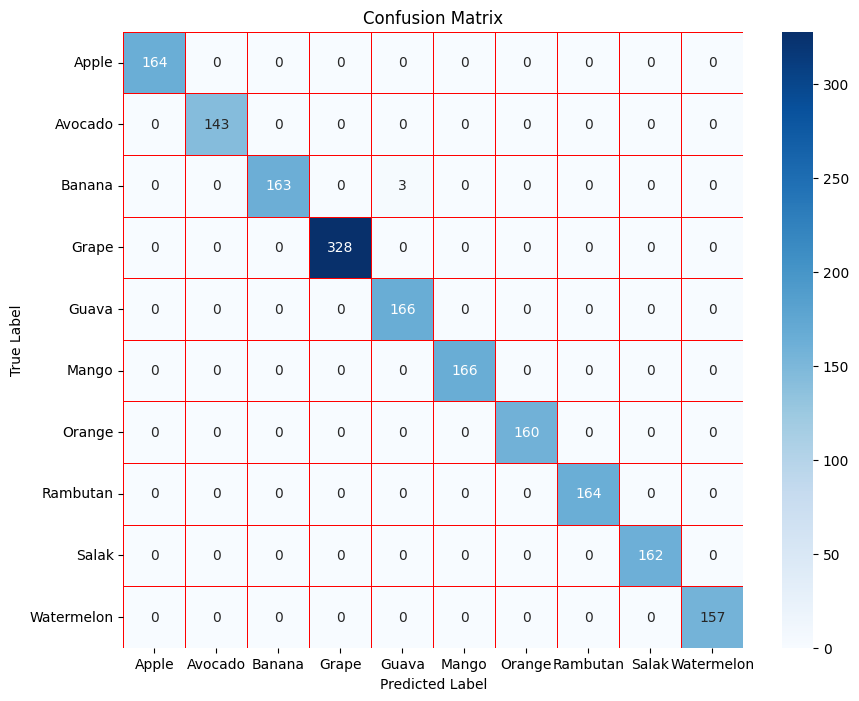

In [19]:
cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')

# Plot CM menggunakan Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0.5,
    xticklabels=class_names,
    yticklabels=class_names,
    linecolor="red",
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Classification Report


In [20]:
# Classification Report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       164
           1       1.00      1.00      1.00       143
           2       1.00      0.98      0.99       166
           3       1.00      1.00      1.00       328
           4       0.98      1.00      0.99       166
           5       1.00      1.00      1.00       166
           6       1.00      1.00      1.00       160
           7       1.00      1.00      1.00       164
           8       1.00      1.00      1.00       162
           9       1.00      1.00      1.00       157

    accuracy                           1.00      1776
   macro avg       1.00      1.00      1.00      1776
weighted avg       1.00      1.00      1.00      1776



# 6. Test Prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


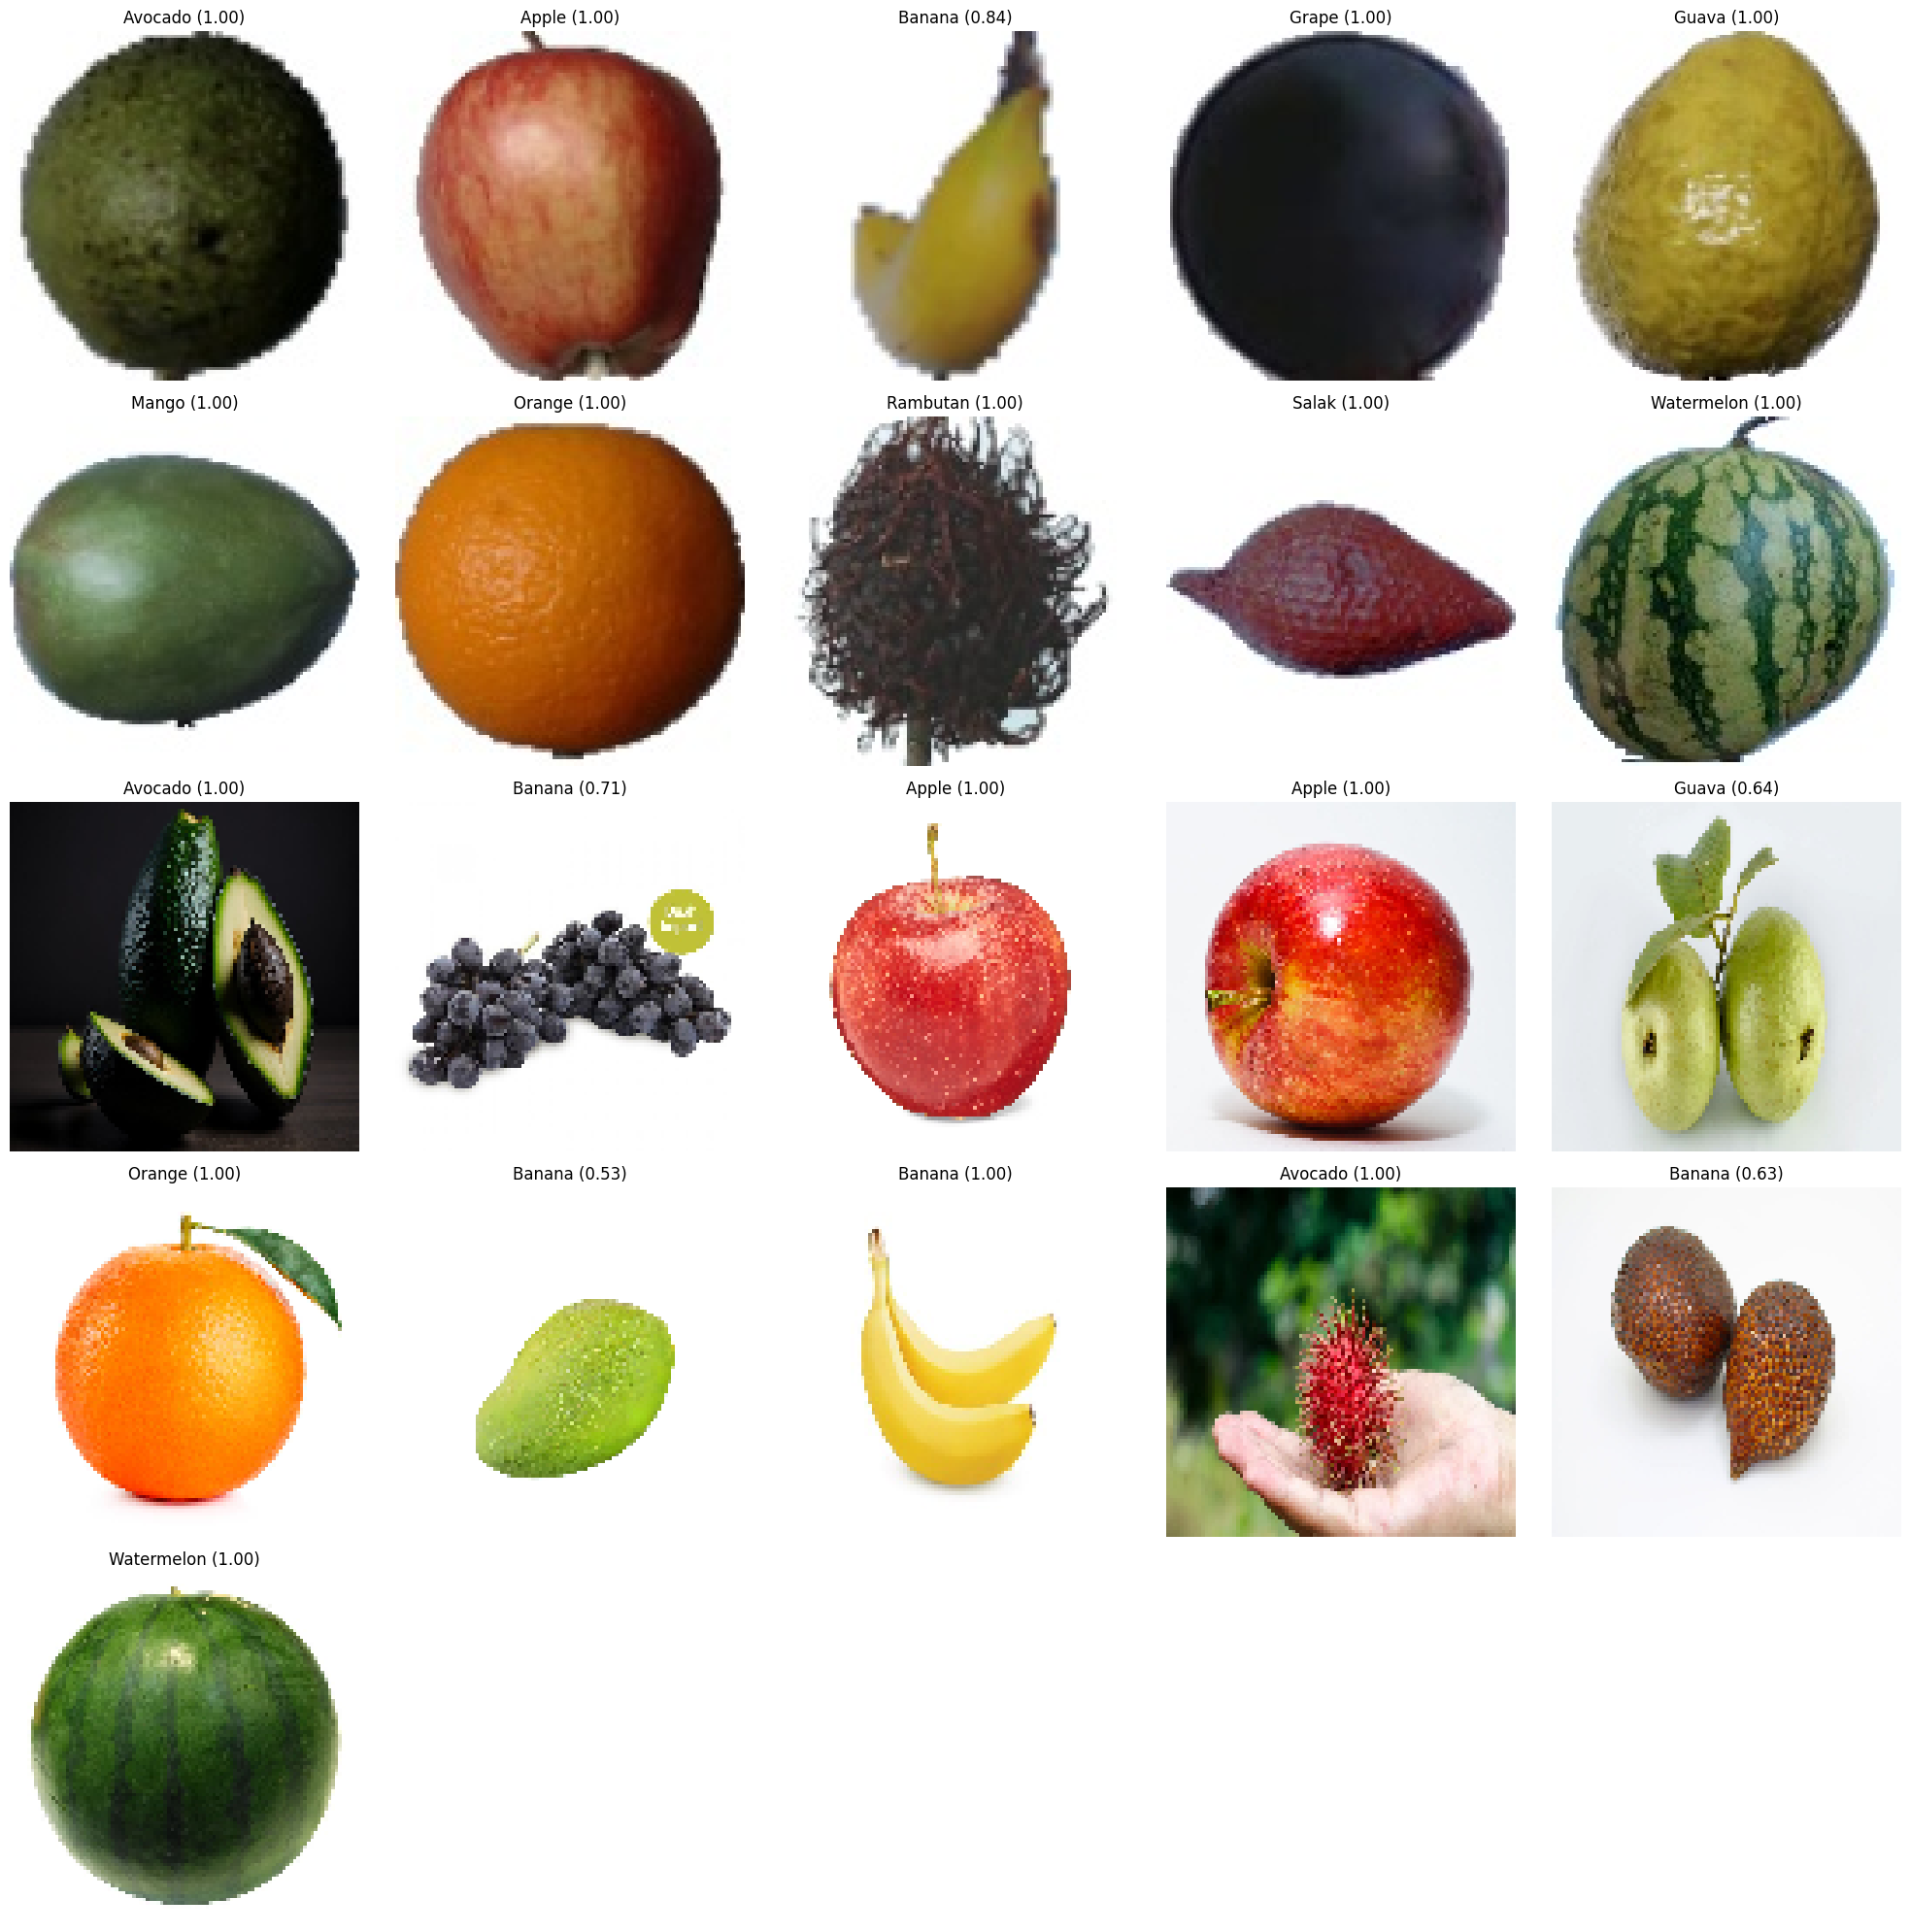

In [22]:
def predict_image(img_path, model, fruits):
    # Memuat dan memproses gambar
    img = image.load_img(img_path, target_size=(100, 100))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    
    # Prediksi gambar
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    predicted_label = [k for k, v in fruits.items() if v == predicted_class][0]
    confidence = np.max(prediction)
    
    return img, predicted_label, confidence

# Daftar gambar untuk prediksi
image_paths = [
    './Dataset/fruits-skripsi/Test/Avocado/r_33_100.jpg',
    './Dataset/fruits-skripsi/Test/Apple/327_100.jpg',
    './Dataset/fruits-skripsi/Test/Banana/15_100.jpg',
    './Dataset/fruits-skripsi/Test/Grape/167_100.jpg',
    './Dataset/fruits-skripsi/Test/Guava/47_100.jpg',
    './Dataset/fruits-skripsi/Test/Mango/r_247_100.jpg',
    './Dataset/fruits-skripsi/Test/Orange/52_100.jpg',
    './Dataset/fruits-skripsi/Test/Rambutan/175_100.jpg',
    './Dataset/fruits-skripsi/Test/Salak/11_100.jpg',
    './Dataset/fruits-skripsi/Test/Watermelon/259_100.jpg',
    "./public/random/alpukat2.png",
    "./public/random/anggur.png",
    "./public/random/apple.jpg",
    "./public/random/apple2.jpg",
    "./public/random/jambu.png",
    "./public/random/jeruk.png",
    "./public/random/mangga.png",
    "./public/random/pisang.jpg",
    "./public/random/rambutan.png",
    "./public/random/salak.png",
    "./public/random/semangka.png"
]

# Mendapatkan label dari generator (misalnya train_generator.class_indices)
fruits = train_gen.class_indices

# Mengatur ukuran figure dan subplot
rows = 5
cols = 5
plt.figure(figsize=(20, 20))

# Menampilkan gambar dan hasil prediksi dalam satu plt
for i, img_path in enumerate(image_paths):
    img, predicted_label, confidence = predict_image(img_path, model, fruits)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"{predicted_label} ({confidence:.2f})")
    plt.axis("off")

plt.tight_layout()
plt.show()